# select CTs topics with enough posts and flatforms
- input: all csv files in `extract_tem3` folder 
- output single csv `extract_tem4.pkl` with 
    - keywords, which are search queries used to collect data, we add NA to mastodon
    - keywords, remapping to topic names (re-organize the keywords)
    - platform, source of the data 
    - keep post relevant columns only, we drop nested links between posts (as the focus here is semantic similarity)
    - keep user relevant columns 
    - drop non-English posts

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import os
from tqdm import tqdm
from bs4 import BeautifulSoup

# 1. Load data and select common columns



In [ ]:
# 1. Load CSV files
def read_csv_platform(platform):
    """
    Read CSV files for the specified platform. This function handles file paths and other platform-specific details.
    
    Parameters:
        platform (str): Name of the platform (e.g., 'tiktok', 'twitter', etc.)
        
    Returns:
        pd.DataFrame: DataFrame containing the platform data with only English posts
    """
    csv_path = "/ct_platform/data/extract_tem3/"
    
    # Initialize dataframe to combine all files for the platform
    df = pd.DataFrame()
    for file in os.listdir(csv_path):
        if file.startswith(platform) and file.endswith('.csv'):
            print(f"Reading file: {file}")
            # Read and combine into one dataframe
            df_tem = pd.read_csv(os.path.join(csv_path, file), dtype=str)
            df = pd.concat([df, df_tem], ignore_index=True)
            print(f"Current combined data rows: {df.shape}")
    
    # Remove duplicates
    df = df.drop_duplicates()
    
    # Add platform column
    df['platform'] = platform

    # Remove non-English posts if language column is available
    if 'post_lan' in df.columns:
        if platform == 'bluesky':
            # Extract language code from ['de'] format to 'de'
            df['post_lan'] = df['post_lan'].str.extract(r'\[(.*?)\]')
            df['post_lan'] = df['post_lan'].str.replace('\'', '')
            # If post_lan is null, set it to 'en'
            df['post_lan'] = df['post_lan'].fillna('en')
            # Keep only posts that contain 'en' in language code
            df = df[df['post_lan'].str.contains('en')]
        else:
            # For other platforms, keep only posts with exact 'en' language code
            df = df[df['post_lan'] == 'en']
            
        # Calculate and display percentage of non-English posts removed
        non_en_pct = (df.shape[0] - df[df['post_lan'] == 'en'].shape[0]) / df.shape[0]
        print(f"Removed {non_en_pct:.2%} of non-English posts.")
        
    print(f"After processing, {platform} dataset has {df.shape[0]} rows with no duplicated IDs.")
    
    return df

In [23]:
platforms = ['tiktok', 'bluesky', 'truthsocial', 'linkedin', 'twitter', 'mastodon', 'gab', 'gettr']
col_list = ['platform','keyword', 'post_id', 'post_time', 'post_text', 'like', 'reply', 'repost',
            'user_id', 'user_name', 'user_fans', 'user_follow', 'user_veri', 'user_desc']
df_all = pd.DataFrame()
column_dict = {}  # Dictionary to store column names for each platform

for platform in platforms:
    try:
        df = read_csv_platform(platform)
        column_dict[platform] = list(df.columns)  # Store read_csv_platform names for each platform
        
        # Check if all columns from col_list are present in the dataframe
        missing_cols = [col for col in col_list if col not in df.columns]
        
        # Add empty columns for missing columns
        for col in missing_cols:
            df[col] = None
            print(f"Added missing column '{col}' to {platform} dataframe")
        
        # Select only the columns we need
        df_selected = df[col_list]
        
        # Append to the combined dataframe
        df_all = pd.concat([df_all, df_selected], ignore_index=True)
        
        print(f"Processed {platform} data: {df_selected.shape[0]} rows")
        
    except Exception as e:
        print(f"Error processing {platform}: {e}")

print(f"Combined dataframe has {df_all.shape[0]} rows and {df_all.shape[1]} columns")


Reading file: tiktok.csv
Current combined data rows: (14741, 25)
After processing, tiktok dataset has 8655 rows with no duplicated IDs.
Added missing column 'user_desc' to tiktok dataframe
Processed tiktok data: 8655 rows
Reading file: bluesky.csv
Current combined data rows: (90169, 15)
Removed 1.74% of non-English posts.
After processing, bluesky dataset has 53362 rows with no duplicated IDs.
Added missing column 'user_fans' to bluesky dataframe
Added missing column 'user_follow' to bluesky dataframe
Added missing column 'user_veri' to bluesky dataframe
Added missing column 'user_desc' to bluesky dataframe
Processed bluesky data: 53362 rows
Reading file: truthsocial.csv
Current combined data rows: (70445, 27)
Removed 0.00% of non-English posts.
After processing, truthsocial dataset has 55871 rows with no duplicated IDs.
Added missing column 'user_desc' to truthsocial dataframe
Processed truthsocial data: 55871 rows
Reading file: linkedin.csv
Current combined data rows: (11385, 20)
Aft

# 2. select most common conspiracies by keywords

this block is to select conspiracy topics, several notes to consider:
1. mastodon has no keywords, so whatever keywors we select in the end, we assume there are some data on mastodon
2. there are 43 conspiracy topics, and 8 platforms, our standard is to select topics that have at least appeared in 4 platforms (+1 mastondon, that will be five platforms)



In [25]:
# Create a mapping dictionary for consistent keyword labels, assisted by Claude
# keyword_mapping = {
    # Aliens/UFO topics
#     'aliens': 'Aliens',
#     'Roswell': 'Aliens',
    
#     # JFK conspiracy
#     'jfk': 'JFK',
    
#     # 9/11 conspiracy
#     '9/11': '9/11',
    
#     # Moon landing conspiracy
#     'moon landing': 'Moon Landing',
#     'moon landing ': 'Moon Landing',
    
#     # Election fraud
#     '2020 election fraud': 'Election Fraud',
#     '#StopTheSteal': 'Election Fraud',
    
#     # Epstein-related
#     'jeffrey epstein': 'Epstein',
#     '#EpsteinDidntKillHimself': 'Epstein',
    
#     # MLK assassination
#     'mlk': 'MLK',
    
#     # Princess Diana
#     'princess diana': 'Princess Diana',
    
#     # Obama birthplace conspiracy
#     'birtherism': 'Birtherism',
    
#     # Birds aren't real
#     'Birds real': 'Birds not Real',
    
#     # Pharmaceutical industry
#     'Big Pharma': 'Big Pharma',
#     '#BigPharmaLies': 'Big Pharma',
    
#     # Bilderberg Group
#     'Bilderberg': 'Bilderberg',
    
#     # FEMA conspiracy
#     'FEMA Camps': 'FEMA Camps',
    
#     # MK-Ultra
#     'MK-Ultra': 'MK-Ultra',
    
#     # Vaccine conspiracies
#     'Vaccination Microchips': 'Vaccine',
#     '#VaccineShedding': 'Vaccine',
#     '#VaccineHoax': 'Vaccine',
#     '#VaccineAgenda': 'Vaccine',
#     'Bill Gates Vaccines': 'Bill Gates',
#     'Bill Gates  Vaccines': 'Bill Gates',
#     '#BillGatesDepopulation': 'Bill Gates',
    
#     # Mandela Effect
#     'Mandela Effect': 'Mandela Effect',
    
#     # George Soros
#     'George Soros Manipulation': 'George Soros',
    
#     # HAARP
#     'HAARP': 'HAARP',
    
#     # Fake Snow
#     'Fake Snow': 'Fake Snow',
    
#     # Deep State
#     '#DeepState': 'Deep State',
#     '#DeepStateExposed': 'Deep State',
#     'Deep State': 'Deep State',
#     'deep state': 'Deep State',
#     'deep-state': 'Deep State',
    
#     # Crisis Actors
#     '#CrisisActors': 'Crisis Actors',
    
#     # 5G conspiracy
#     '#5GConspiracy': '5G',
#     'COVID 5G': '5G',
    
#     # Event 201
#     '#Event201': 'Event 201',
    
#     # Globalist agenda
#     '#GlobalistAgenda': 'Globalist Agenda',
    
#     # New World Order
#     '#NWO': 'New World Order',
#     'new world order': 'New World Order',
#     '#NewWorldOrder': 'New World Order',
    
#     # Truth Seekers
#     '#TruthSeekers': 'Truth Seekers',
    
#     # Black Helicopters
#     '#BlackHelicopters': 'Black Helicopters',
    
#     # Eugenics
#     '#Eugenics': 'Eugenics',
    
#     # End The Fed
#     '#EndTheFed': 'End The Fed',
    
#     # Red Pill
#     '#RedPill': 'Red Pill',
    
#     # Controlled Opposition
#     '#ControlledOpposition': 'Controlled Opposition',
    
#     # Cabal
#     '#Cabal': 'Cabal',
#     'Cabal': 'Cabal',
    
#     # COVID-19
#     'covid-19': 'COVID-19',
#     'covid 19': 'COVID-19',
#     '#Plandemic': 'COVID-19',
    
#     # Illuminati
#     'illuminati': 'Illuminati',
#     '#Illuminati': 'Illuminati',
    
#     # Chemtrails
#     'chemtrails': 'Chemtrails',
#     '#Chemtrails': 'Chemtrails',
    
#     # Flat Earth
#     'flat earth': 'Flat Earth',
#     '#FlatEarth': 'Flat Earth',
    
#     # Great Reset
#     'Great Reset': 'Great Reset',
#     '#GreatReset': 'Great Reset',
#     '#Agenda2030': 'Great Reset',
    
#     # QAnon
#     'QAnon': 'QAnon',
#     '#QAnon': 'QAnon',
#     '#GreatAwakening': 'QAnon',
#     '#WWG1WGA': 'QAnon',
    
#     # Pedogate/Pizzagate
#     '#Pedogate': 'Pizzagate',
#     '#PizzaGate': 'Pizzagate',
    
#     # False Flag
#     '#FalseFlag': 'False Flag',
    
#     # Lizard People
#     '#LizardPeople': 'Lizard People'
# }

# Create a mapping dictionary, to recategorize keywords into five focal conspiracy categories 
keyword_mapping = {
    # Aliens/UFO topics
    'aliens': 'Aliens',
    'Roswell': 'Aliens',
    
    # JFK conspiracy
    'jfk': 'Irrelevant',
    
    # 9/11 conspiracy
    '9/11': '9/11',
    
    # Moon landing conspiracy
    'moon landing': 'Moon Landing',
    'moon landing ': 'Moon Landing',
    
    # Election fraud
    '2020 election fraud': 'Irrelevant',
    '#StopTheSteal': 'Irrelevant',
    
    # Epstein-related
    'jeffrey epstein': 'Irrelevant',
    '#EpsteinDidntKillHimself': 'Irrelevant',
    
    # MLK assassination
    'mlk': 'Irrelevant',
    
    # Princess Diana
    'princess diana': 'Irrelevant',
    
    # Obama birthplace conspiracy
    'birtherism': 'Irrelevant',
    
    # Birds aren't real
    'Birds real': 'Irrelevant',
    
    # Pharmaceutical industry
    'Big Pharma': 'Irrelevant',
    '#BigPharmaLies': 'Irrelevant',
    
    # Bilderberg Group
    'Bilderberg': 'Illuminati/New World Order',
    
    # FEMA conspiracy
    'FEMA Camps': 'Irrelevant',
    
    # MK-Ultra
    'MK-Ultra': 'Irrelevant',
    
    # Vaccine conspiracies
    'Vaccination Microchips': 'COVID-19',
    '#VaccineShedding': 'COVID-19',
    '#VaccineHoax': 'COVID-19',
    '#VaccineAgenda': 'COVID-19',
    'Bill Gates Vaccines': 'COVID-19',
    'Bill Gates  Vaccines': 'COVID-19',
    '#BillGatesDepopulation': 'COVID-19',
    
    # Mandela Effect
    'Mandela Effect': 'Irrelevant',
    
    # George Soros
    'George Soros Manipulation': 'Irrelevant',
    
    # HAARP
    'HAARP': 'Irrelevant',
    
    # Fake Snow
    'Fake Snow': 'Irrelevant',
    
    # Deep State
    '#DeepState': 'Illuminati/New World Order',
    '#DeepStateExposed': 'Illuminati/New World Order',
    'Deep State': 'Illuminati/New World Order',
    'deep state': 'Illuminati/New World Order',
    'deep-state': 'Illuminati/New World Order',
    
    # Crisis Actors
    '#CrisisActors': 'Irrelevant',
    
    # 5G conspiracy
    '#5GConspiracy': 'Irrelevant',
    'COVID 5G': 'COVID-19',
    
    # Event 201
    '#Event201': 'COVID-19',
    
    # Globalist agenda
    '#GlobalistAgenda': 'Illuminati/New World Order',
    
    # New World Order
    '#NWO': 'Illuminati/New World Order',
    'new world order': 'Illuminati/New World Order',
    '#NewWorldOrder': 'Illuminati/New World Order',
    
    # Truth Seekers
    '#TruthSeekers': 'Irrelevant',
    
    # Black Helicopters
    '#BlackHelicopters': 'Irrelevant',
    
    # Eugenics
    '#Eugenics': 'Irrelevant',
    
    # End The Fed
    '#EndTheFed': 'Irrelevant',
    
    # Red Pill
    '#RedPill': 'Irrelevant',
    
    # Controlled Opposition
    '#ControlledOpposition': 'Irrelevant',
    
    # Cabal
    '#Cabal': 'Illuminati/New World Order',
    'Cabal': 'Illuminati/New World Order',
    
    # COVID-19
    'covid-19': 'COVID-19',
    'covid 19': 'COVID-19',
    '#Plandemic': 'COVID-19',
    
    # Illuminati
    'illuminati': 'Illuminati/New World Order',
    '#Illuminati': 'Illuminati/New World Order',
    
    # Chemtrails
    'chemtrails': 'Irrelevant',
    '#Chemtrails': 'Irrelevant',
    
    # Flat Earth
    'flat earth': 'Irrelevant',
    '#FlatEarth': 'Irrelevant',
    
    # Great Reset
    'Great Reset': 'Illuminati/New World Order',
    '#GreatReset': 'Illuminati/New World Order',
    '#Agenda2030': 'Illuminati/New World Order',
    
    # QAnon
    'QAnon': 'Irrelevant',
    '#QAnon': 'Irrelevant',
    '#GreatAwakening': 'Irrelevant',
    '#WWG1WGA': 'Irrelevant',
    
    # Pedogate/Pizzagate
    '#Pedogate': 'Irrelevant',
    '#PizzaGate': 'Irrelevant',
    
    # False Flag
    '#FalseFlag': 'Irrelevant',
    
    # Lizard People
    '#LizardPeople': 'Irrelevant'
}
# Function to map keywords to standardized categories
def map_keyword(keyword):
    if pd.isna(keyword):
        return np.nan
    return keyword_mapping.get(keyword, keyword)

# Create a new column with mapped keywords
df_all['topic_5'] = df_all['keyword'].apply(map_keyword)


In [26]:
# See the distribution of standardized keywords
keyword_distribution = df_all.groupby('topic_5')['platform'].value_counts()
pd.set_option('display.max_rows', None)  # Show all rows
print(keyword_distribution)

topic_5                     platform   
9/11                        twitter        194698
                            bluesky         13985
                            truthsocial      4504
                            gab              1531
                            linkedin         1024
                            tiktok            426
                            gettr             127
Aliens                      twitter        694466
                            bluesky          9650
                            truthsocial      6114
                            linkedin         1894
                            gab              1723
                            tiktok            952
                            gettr             102
COVID-19                    twitter        252937
                            truthsocial     12565
                            bluesky         12251
                            gab              3412
                            tiktok            356
          

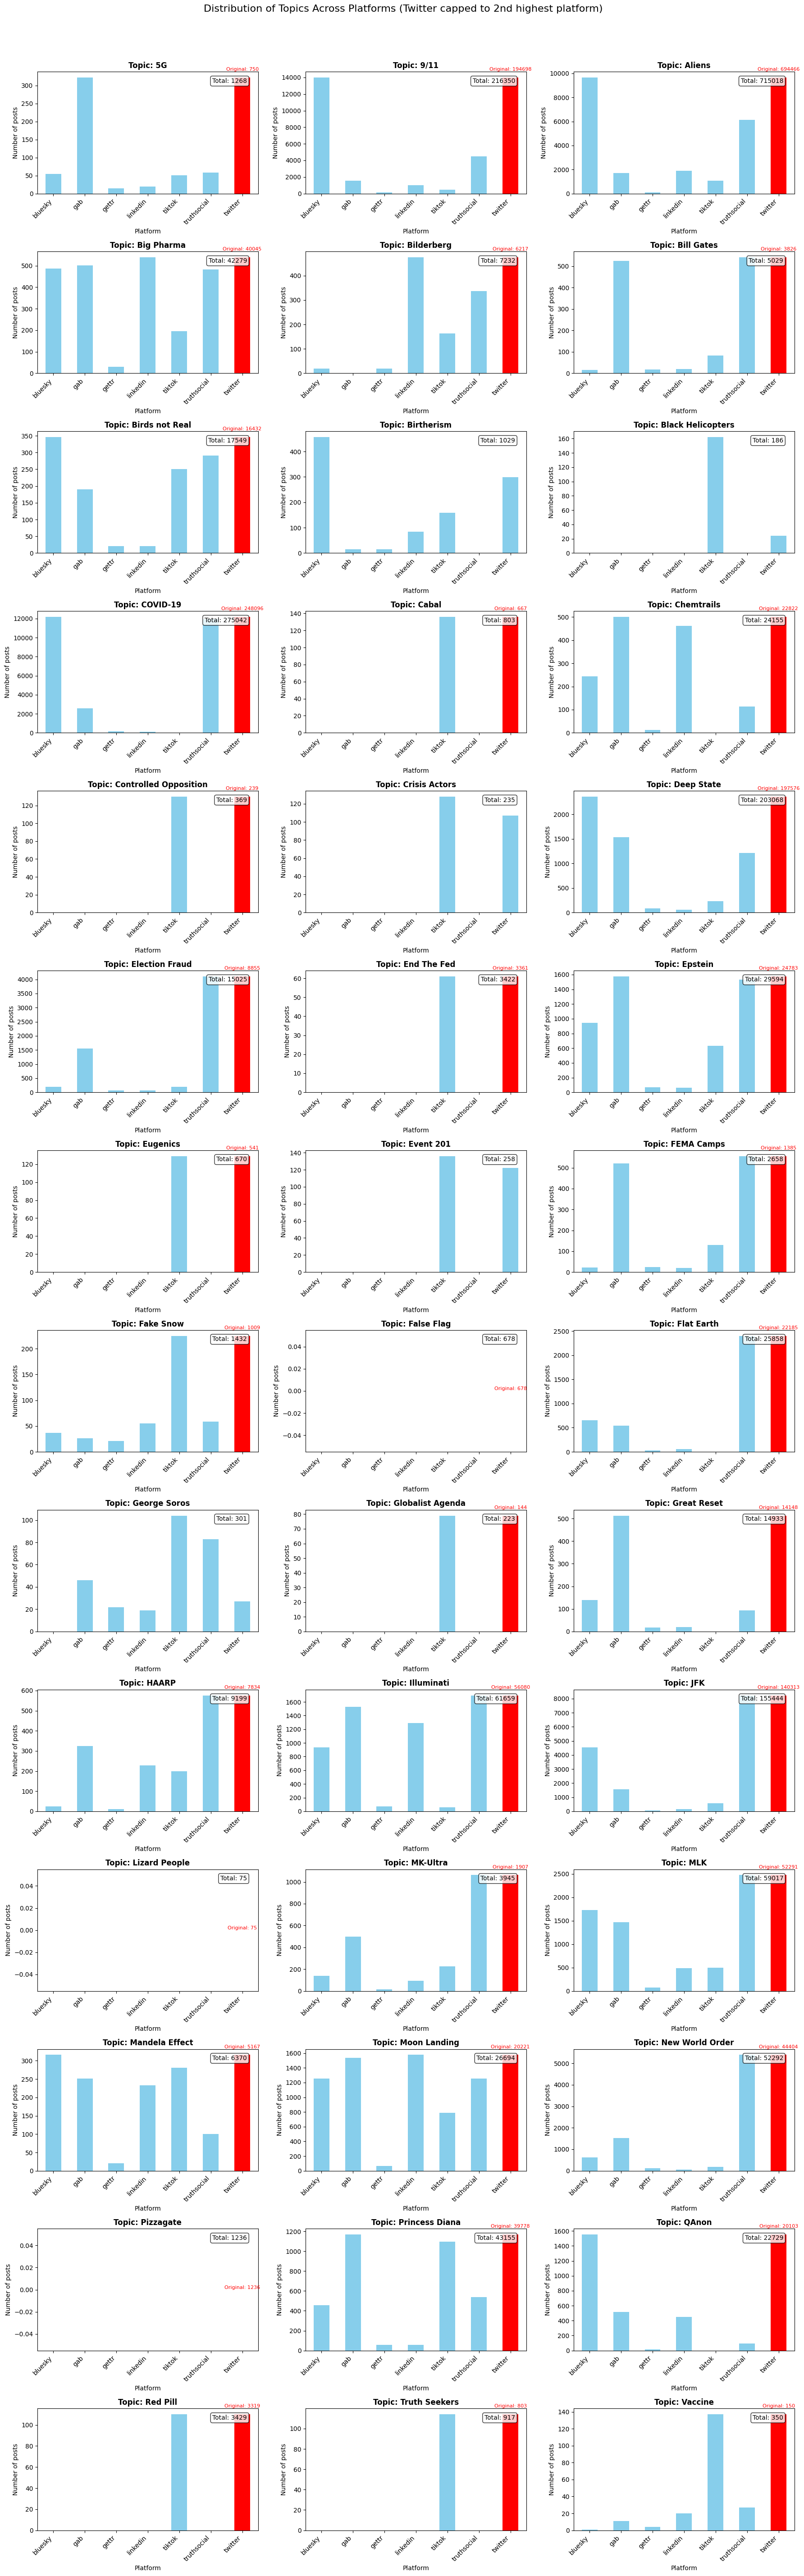

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Create a cross-tabulation of topics and platforms
# topic_platform_counts = pd.crosstab(df_all['topic'], df_all['platform'])

# # Get list of topics (excluding NaN)
# topics = df_all['topic'].dropna().unique()

# # Calculate number of rows and columns for subplots
# n_topics = len(topics)
# n_cols = 3  # Number of columns in the grid
# n_rows = (n_topics + n_cols - 1) // n_cols  # Calculate rows needed

# # Create a figure with subplots
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
# axes = axes.flatten()  # Flatten to make indexing easier

# # Loop through each topic and create a subplot
# for i, topic in enumerate(sorted(topics)):
#     if i < len(axes):  # Ensure we don't exceed the number of axes
#         if topic in topic_platform_counts.index:
#             # Get counts for this topic across platforms
#             topic_data = topic_platform_counts.loc[topic].copy()
            
#             # Cap Twitter values to the second highest platform value
#             if 'twitter' in topic_data.index:
#                 # Find the second highest value (excluding Twitter)
#                 values_without_twitter = topic_data.drop('twitter', errors='ignore')
#                 if not values_without_twitter.empty:
#                     second_highest = values_without_twitter.sort_values(ascending=False).iloc[0]
                    
#                     # Store the original Twitter value
#                     original_twitter_value = topic_data['twitter']
                    
#                     # Cap Twitter value
#                     if topic_data['twitter'] > second_highest:
#                         topic_data['twitter'] = second_highest
                    
#                     # Create bar plot
#                     ax = axes[i]
#                     bars = topic_data.plot(kind='bar', ax=ax, color='skyblue')
                    
#                     # Mark the capped Twitter bar with a different color and annotation
#                     if original_twitter_value > second_highest:
#                         twitter_idx = topic_data.index.get_loc('twitter')
#                         bars.patches[twitter_idx].set_facecolor('red')
#                         ax.text(twitter_idx, second_highest * 1.05, 
#                                 f'Original: {original_twitter_value}', 
#                                 ha='center', va='bottom', rotation=0,
#                                 fontsize=8, color='red')
#                 else:
#                     # Create regular bar plot if there's only Twitter
#                     ax = axes[i]
#                     topic_data.plot(kind='bar', ax=ax, color='skyblue')
#             else:
#                 # Create regular bar plot if Twitter is not present
#                 ax = axes[i]
#                 topic_data.plot(kind='bar', ax=ax, color='skyblue')
            
#             # Customize subplot
#             ax.set_title(f"Topic: {topic}", fontweight='bold')
#             ax.set_xlabel('Platform')
#             ax.set_ylabel('Number of posts')
            
#             # Add total count in the right top corner
#             original_total = topic_platform_counts.loc[topic].sum()
#             ax.text(0.95, 0.95, f'Total: {original_total}', 
#                     transform=ax.transAxes,
#                     ha='right', va='top',
#                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
#             # Rotate x-axis labels for better readability
#             plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# # Hide any unused subplots
# for j in range(i + 1, len(axes)):
#     axes[j].axis('off')

# plt.tight_layout()
# plt.suptitle('Distribution of Topics Across Platforms (Twitter capped to 2nd highest platform)', fontsize=16, y=1.02)
# plt.show()

# # Save the figure
# # plt.savefig('topic_distribution_by_platform_twitter_capped.png', bbox_inches='tight', dpi=300)

select topics that are common across at least 4 platforms with at least 100 posts 

In [27]:
df_all.columns

Index(['platform', 'keyword', 'post_id', 'post_time', 'post_text', 'like',
       'reply', 'repost', 'user_id', 'user_name', 'user_fans', 'user_follow',
       'user_veri', 'user_desc', 'topic_5'],
      dtype='object')

In [28]:
# 
topic_platform_counts = pd.crosstab(df_all['topic_5'], df_all['platform'])
# use percentage, count the percentage of each topic on each platform
topic_platform_counts_pct = topic_platform_counts.div(topic_platform_counts.sum(axis=1), axis=0) * 100
topic_platform_counts_pct = (topic_platform_counts_pct >= 0.10).sum(axis=1)
# select topics that appear on at least 4 platforms 
qualifying_topics = topic_platform_counts_pct[topic_platform_counts_pct >= 4].index.tolist()

print(len(qualifying_topics))
print(qualifying_topics)


6
['9/11', 'Aliens', 'COVID-19', 'Illuminati/New World Order', 'Irrelevant', 'Moon Landing']


# 3. the full dataset 
- output: `/home/misinfo/turing_dso_misinfo/ct_platform/data/extract_tem4.csv`


In [31]:
# filter the dataframe for platform comparison next step
# dont forget to include mastodon!! it has na keyword column
df = df_all[df_all['topic_5'].isin(qualifying_topics) | df_all['topic_5'].isna()]
df['platform'].value_counts()
# df[df['platform']=='truthsocial']['post_text'].isna().sum()
# df.to_csv('/home/misinfo/turing_dso_misinfo/ct_platform/data/extract_tem4.csv', index=False)

platform
twitter        1897183
truthsocial      55871
bluesky          53362
gab              24554
mastodon         18128
linkedin          9625
tiktok            8655
gettr             1359
Name: count, dtype: int64

In [33]:
twt_row = df[df['platform'] == 'twitter'].shape[0]
twt_per = twt_row / df.shape[0] * 100
print(f"Filtered dataframe has {df.shape[0]} rows across {df['platform'].nunique()} platforms and {df['topic_5'].nunique()} topics.")
print(f"note that {twt_per:.2f}% of the data is from Twitter")

Filtered dataframe has 2068737 rows across 8 platforms and 6 topics.
note that 91.71% of the data is from Twitter


In [34]:
def remove_urls(text):
    """
    Remove all URLs from the text
    """
    if isinstance(text, str):
        # Regular expression to match standard URLs
        url_pattern = r'https?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
        clean_text = re.sub(url_pattern, '', text)
        
        # Handle the broken/partial URLs with "invisible" and "ellipsis" spans
        partial_url_pattern = r'https?://\S*'
        clean_text = re.sub(partial_url_pattern, '', clean_text)
        
        # Handle domain patterns
        domain_pattern = r'\s(?:www\.|(?:[\w-]+\.)+(?:com|net|org|edu|gov|mil|biz|info|io|me|tv|[\w]{2,}))\S*'
        clean_text = re.sub(domain_pattern, ' ', clean_text)
        
        # Clean up any remaining URL fragments
        fragments_pattern = r'(?:press\.coop|gab\.com|youtube\.com|bitchute\.com|imdb\.com)\/\S*'
        clean_text = re.sub(fragments_pattern, '', clean_text)
        
        return clean_text
    return text

def clean_text(text):
    """
    Comprehensive text cleaning function 
    """
    if isinstance(text, str):        
        # Then remove URLs
        text = remove_urls(text)
        
        # # Remove any remaining numeric fragments that might be URL parts
        # text = re.sub(r'\d{10,}', '', text)
        
        # Remove special characters and multiple spaces
        text = re.sub(r'\s+', ' ', text)
        text = text.strip()
        
        return text
    return text

In [ ]:
df_post2claim = df.copy()
# df_post2claim = df[['post_id', 'post_text', 'platform', 'topic']]
print(f"after selecting 29 CTs: {df_post2claim.shape}")
df_post2claim = df_post2claim.drop_duplicates()
print(f"after remove duplicates: {df_post2claim.shape}")
df_post2claim = df_post2claim.dropna(subset=['post_id','post_text'])
print(f"after remove na: {df_post2claim.shape}")


# as we are studying the narrative, we need to do some preprocessing of texts 
df_post2claim['clean_post_text'] = df_post2claim['post_text'].apply(clean_text)
df_post2claim = df_post2claim[df_post2claim['clean_post_text'].str.len() > 5]
print(f"after remove empty post_text: {df_post2claim.shape}")
df_post2claim['platform'].value_counts()

df_post2claim = df_post2claim[df_post2claim['topic_5'] != 'Irrelevant']
print(f"after remove irrelavant topics: {df_post2claim.shape}")

# save to pickle, all as strings
df_post2claim.to_pickle('/ct_platform/data/extract_tem4.pkl')



after selecting 29 CTs: (2068737, 15)
after remove duplicates: (2014650, 15)
after remove na: (2011739, 15)
after remove empty post_text: (2007453, 16)
after remove irrelavant topics: (1554700, 16)


In [ ]:
size_bytes = os.path.getsize('/ct_platform/data/extract_tem4.pkl')
size_mb = size_bytes / (1024 * 1024)  # Convert to MB

print(f"File size: {size_bytes:,} bytes")
print(f"File size: {size_mb:.2f} MB")

File size: 868,206,664 bytes
File size: 827.99 MB


# 4. sample a subset of posts for tasks
1. posts to claims
2. binary conspiracy classification

- we test prompts and model over a small set of data.
- we sampled 5 topics from 8 platforms, for each topic we sample 10 posts from each platform. in total we have 5*8*10=400 posts.

In [ ]:
# df_platform = df_post2claim.copy()
# df_platform = df_platform.dropna(subset=['post_text'], how='all')
# # we selected following topics 
# # sample_topic = ['5G','COVID-19', 'Vaccine','9/11', 'Moon Landing', 'JFK', 'Aliens']

# sample_df = pd.DataFrame()
# for platform in df_platform['platform'].unique():
#     if platform == 'mastodon':
#         # randomly sample 40 rows 
#         sample = df_platform[(df_platform['platform'] == platform)].sample(n=40, random_state=42)
#         print(f"Platform: {platform}, Sampled Rows: {len(sample)}")
#     else:
#         sample = pd.DataFrame()
#         for topic in df_platform['topic_5'].unique():
#             df_tem = df_platform[(df_platform['platform'] == platform) & (df_platform['topic_5'] == topic)]
#             if not df_tem.empty:
#                 sample_size = min(10, len(df_tem))
#                 df_tem2 = df_tem.sample(n=sample_size, random_state=42)
#                 sample = pd.concat([sample, df_tem2], axis = 0,ignore_index=True) # rowbind
#             print(f"Platform: {platform}, Topic: {topic}, Sampled Rows: {len(sample)}")
#     sample_df = pd.concat([sample_df, sample], axis = 0,ignore_index=True) # rowbind

Platform: tiktok, Topic: Illuminati/New World Order, Sampled Rows: 10
Platform: tiktok, Topic: COVID-19, Sampled Rows: 20
Platform: tiktok, Topic: Aliens, Sampled Rows: 30
Platform: tiktok, Topic: 9/11, Sampled Rows: 40
Platform: tiktok, Topic: Moon Landing, Sampled Rows: 50
Platform: tiktok, Topic: nan, Sampled Rows: 50
Platform: bluesky, Topic: Illuminati/New World Order, Sampled Rows: 10
Platform: bluesky, Topic: COVID-19, Sampled Rows: 20
Platform: bluesky, Topic: Aliens, Sampled Rows: 30
Platform: bluesky, Topic: 9/11, Sampled Rows: 40
Platform: bluesky, Topic: Moon Landing, Sampled Rows: 50
Platform: bluesky, Topic: nan, Sampled Rows: 50
Platform: truthsocial, Topic: Illuminati/New World Order, Sampled Rows: 10
Platform: truthsocial, Topic: COVID-19, Sampled Rows: 20
Platform: truthsocial, Topic: Aliens, Sampled Rows: 30
Platform: truthsocial, Topic: 9/11, Sampled Rows: 40
Platform: truthsocial, Topic: Moon Landing, Sampled Rows: 50
Platform: truthsocial, Topic: nan, Sampled Rows

In [ ]:
# sample_df

,platform,keyword,post_id,post_time,post_text,like,reply,repost,user_id,user_name,user_fans,user_follow,user_veri,user_desc,topic
0,tiktok,#5GConspiracy,7112904128870763818,1656102049,Beware of 5G!!! The internet said so!! #5g #ca...,68,8,1,6779621535118246917,WhistleOut,7624,74,False,None,5G
1,tiktok,#5GConspiracy,7124778186075852074,1658866694,Source - thescottishfarmer.co.uk #awareness #5...,801,43,124,7109787446581167150,PieForYourLies,2437,1108,False,None,5G
2,tiktok,#5GConspiracy,7275788724019924267,1694026579,A full length documentary exposing the 5G thre...,48,2,38,6805083213733446661,Bee_Love,70,24,False,None,5G
3,tiktok,#5GConspiracy,7395892897482100000,1721990516,The Drumsticks are not real ice cream 💀 #drums...,39300,1188,51600,7352781711569617952,conspiracies.tok,11800,14,False,None,5G
4,tiktok,#5GConspiracy,7301427628265753898,1699996103,Hollywood conspiracy throwback. That's so this...,12700,451,1047,6680292855980934150,GhostToast,670400,90,False,None,5G
5,tiktok,#5GConspiracy,6911699180356406534,1609255389,#emfprotection #conspiracy #conspiracytheorie...,284,10,20,6894066596009935877,Christopher Consciousness,2818,971,False,None,5G
6,tiktok,#5GConspiracy,7338449673503378730,1708615970,Can this be a good thing for your body if 5G i...,36,3,3,7276911306338780202,The Happening,982,382,False,None,5G
7,tiktok,#5GConspiracy,7378066728300875041,1717840035,The 5G Mind Control Theory… ##conspiracy##cons...,41,2,0,7277730082294383649,EclecticRealm,112,3,False,None,5G
8,tiktok,#5GConspiracy,6813036073430666502,1586283575,I can’t take the conspiracy theories anymore 😫...,42,1,0,6809355828676543493,Bigz,117,190,False,None,5G
9,tiktok,#5GConspiracy,7334047090001366318,1707590938,#ad | The Numen Air is perfect for people that...,124300,361,134000,7191102679179035691,Hunter | AAFPS,147000,363,False,None,5G


In [ ]:
# # save the sample dataframe
# sample_df = sample_df[["platform", "topic","post_text","post_time"]]
# sample_df.to_csv('/ct_platform/data/extract_tem4_sample.csv', index=False)